Some examples of manipulation of transition matrices

In [85]:
import numpy as np
import seaborn as sns
from indemmar import plot_and_legend
from pathlib import Path
from matplotlib import pyplot as plt
import numpy.linalg as la
import moments
import scipy
from subprocess import run
plt.rc('font', family='serif', size=16)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.style.use('seaborn')


The script to generate a Q matrix is written in C, and outputs the matrix to a file. 

We will write a function that cattempts to read a matrix file and generates it if it doesn't exist.  

In [86]:
data_store = Path.cwd() / Path("../data")

def read_Q(N, Ns, no, k, j):
    try:
        QT = np.loadtxt(data_store / Path(f"q_mat_{N}_{Ns}_{no}_{k}_{j}.txt"))
    except OSError:
        print("Q matrix",data_store / Path(f"q_mat_{N}_{Ns}_{no}_{k}_{j}.txt"), "was likely not found." 
          " Attempting to generate matrix " )
        run(["./compute_Q_from_scratch.sh",f"{N}", f"{Ns}", f"{no}", f"{k}", f"{j}"])
        QT = np.loadtxt(data_store / Path(f"q_mat_{N}_{Ns}_{no}_{k}_{j}.txt"))
    
    
    return QT.T 

In [178]:
large_pop_size = 100000
small_pop_size = 400
sample_size = 100
s_del = 0.0024
j = 7
k = 3

Q_small_neutral = read_Q(N=small_pop_size, Ns=0, no=sample_size, k=0, j=0)

Q_small_del = read_Q(N=small_pop_size, Ns=small_pop_size*s_del, no=sample_size, k=k, j=j)


Q_large_neutral = read_Q(N=large_pop_size, Ns=0, no=sample_size, k=0, j=0)

Q_large_del = read_Q(N=large_pop_size, Ns=large_pop_size*s_del, no=sample_size, k=k, j=j)

Q matrix /Users/simongravel/projects/disco/src/../data/q_mat_400_0_100_0_0.txt was likely not found. Attempting to generate matrix 
Q matrix /Users/simongravel/projects/disco/src/../data/q_mat_400_0.96_100_3_7.txt was likely not found. Attempting to generate matrix 
Q matrix /Users/simongravel/projects/disco/src/../data/q_mat_100000_0_100_0_0.txt was likely not found. Attempting to generate matrix 
Q matrix /Users/simongravel/projects/disco/src/../data/q_mat_100000_239.99999999999997_100_3_7.txt was likely not found. Attempting to generate matrix 


Using values from compute_Q_from_scratch.py



Test whether the columns of Q (and rows to QT) sum to 1. 

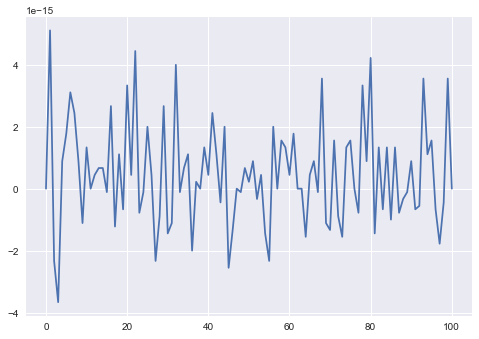

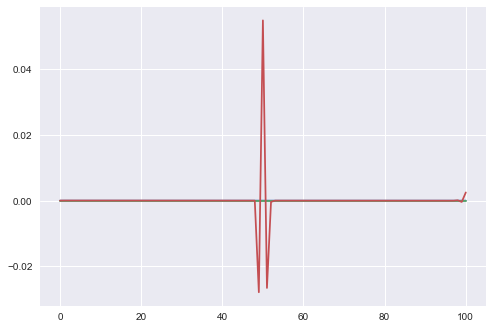

In [179]:
plt.plot(Q_small_neutral.sum(axis=0)-1);
plt.figure()
plt.plot(Q_small_del.sum(axis=0)-1)
plt.plot(Q_large_neutral.sum(axis=0)-1)
plt.plot(Q_large_del.sum(axis=0)-1)

This lack of normalization in the large_del matrix looks scary, but it is fine as long as the SFS itself is smooth around f=0.5. This is discussed in issue #6. 

### Infinite-sites model

To compute the equilibrium distribution in the infinite-sites model, we can simply solve the linear equation. Here we take a sample of size 2 for simplicity: 

In [180]:
n_het=2  # sample size for heterozygosity
Q2 = Q_small_neutral = read_Q(N=small_pop_size, Ns=0, no=n_het, k=0, j=0)

mu = 1e-8
predicted_pi = 2*mu*small_pop_size

#this code was copied and modified from Spectra.py   
I = np.eye(n_het - 1)
z = np.zeros(n_het - 1)
z[0] = (n_het) * mu
pi = la.solve((Q2[1:-1, 1:-1] - I).T, -z)

print("computed: pi", pi)
print("Expectation 2 N mu", predicted_pi)


Q matrix /Users/simongravel/projects/disco/src/../data/q_mat_400_0_2_0_0.txt was likely not found. Attempting to generate matrix 
computed: pi [8.e-06]
Expectation 2 N mu 8e-06


### Finite sites model

Repeat the calculation under the finite sites model


In [181]:
# Load the reversible mutation matrix from moments
sparse_mutation = moments.LinearSystem_1D.calcB_FB(n_het+1,mu,mu)

# Add the identity matrix to obtain the recursion in the standard format
transition_mutation = sparse_mutation.toarray()+np.eye(n_het+1)


The SD matrix applies selection and drift first, to generate the unmutated alleles that would have been inherited by the offspring without mutation. The the mutation matrix acts on these trasmitted gametes.  

In [182]:
np.array([.5, pi[0],5]).reshape((3,1))

array([[5.e-01],
       [8.e-06],
       [5.e+00]])

In [183]:
I3 = np.eye(n_het +1)
eigs = np.linalg.eig((MQT - I3))

#eig should be normalized to sum to 1
eigenvector = eigs[1][:,-1]/eigs[1][:,-1].sum()

print("eigenvector corresponding to eigenvalue", eigs[0][-1]," is\n", eigenvector) 

eigenvector corresponding to eigenvalue 1.0526332028311752e-17  is
 [4.99999000e-01 1.99999208e-06 4.99999000e-01]


Note the modest difference with the infinite-sites model. There are modest differences between the two models. For example the creation of new heterozygotes in the finite sites model is slightly lower due to the fact that mutation only creates heterozygotes from fixed sites, of which there are $1-\pi$, whereas the infinite-sites model assumes a fixed rate of mutation.     

 ### Modelling a bottleneck
 
To model a bottleneck, we will use two matrices, corresponding to large ($NL=100 000$) and bottlenecked ($NB=100$) population sizes. We will choose $s = 0.01$ so that $NBs = 1$
 
 

In [216]:
# Equilibrium spectrum for large vs small population, infinite-sites model

I = np.eye(sample_size - 1)
z_short = np.zeros(sample_size - 1)
z_short[0] = (sample_size) * mu
sfs_large = la.solve((Q_large_del[1:-1, 1:-1] - I), -z_short)
sfs_bottle = la.solve((Q_small_del[1:-1, 1:-1] - I), -z_short)

Text(0, 0.5, 'proportion of sites')

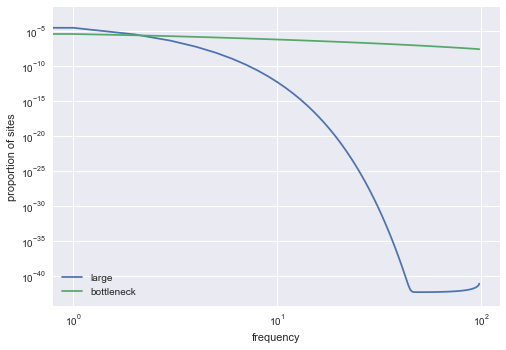

In [217]:
plt.loglog(sfs_large,label = 'large')
plt.loglog(sfs_bottle,label = 'bottleneck')
plt.legend(loc = "lower left")
plt.xlabel('frequency')
plt.ylabel('proportion of sites')

Compute out-of-equilibrium SFS

In [186]:
n_generations = 1000
list_sfs_WF = [np.hstack((sfs_large,[0]))]

z = np.zeros(sample_size)
z[0] = (sample_size) * mu
for _ in range(n_generations):
    list_sfs_WF.append(np.dot(Q_small_del[1:,1:],list_sfs_WF[-1]) + z)

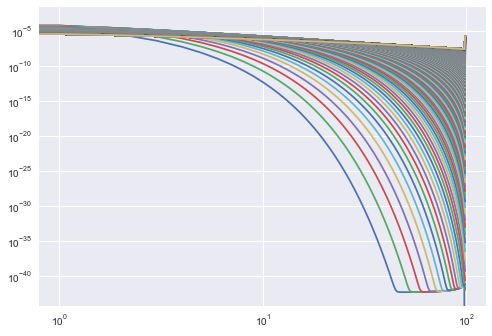

In [187]:
[plt.loglog(sfs) for sfs in list_sfs_WF];

Do the same using the moments transition matrix! 

To get the equilibrium value, note that these are instantaneous rates, so that we want the limit

$$\lim_{k\rightarrow \infty}(I+ (D+S)/k)^k = e^{D+S}$$ 



In [188]:
h = 0.5
D_matrix = (1/2./small_pop_size) * moments.LinearSystem_1D.calcD(sample_size+1).toarray()
S_matrix = s_del *h* moments.LinearSystem_1D.calcS(sample_size+1, moments.Jackknife.calcJK13(sample_size))
moment_matrix_small_del = scipy.linalg.expm(D_matrix+S_matrix.toarray())

We'll assume here that mutations in both models are introduced once per generation, to compare the differences in drift and selection modelling.

In [189]:


I = np.eye(sample_size-1)

moment_smallpop_equil = la.solve((moment_matrix_small_del[1:-1, 1:-1] - I), -z_short)
WF_smallpop_equil = la.solve((Q_small_del[1:-1, 1:-1] - I), -z_short)

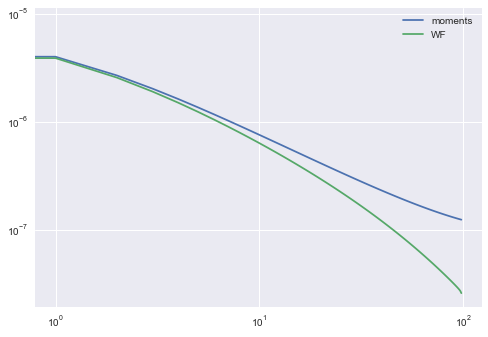

In [190]:
plt.loglog(moment_smallpop_equil,label = "moments")
plt.loglog(WF_smallpop_equil,label = 'WF')
plt.legend(loc = "upper right")

In [223]:
## Estimating load

print("load in diffusion", s_del*np.dot(np.arange(sample_size-1)+1, moment_smallpop_equil ))
print("load in WF", s_del*np.dot(np.arange(sample_size-1)+1, WF_smallpop_equil ))



load in diffusion 2.370633300094866e-06
load in WF 1.1262679440692724e-06


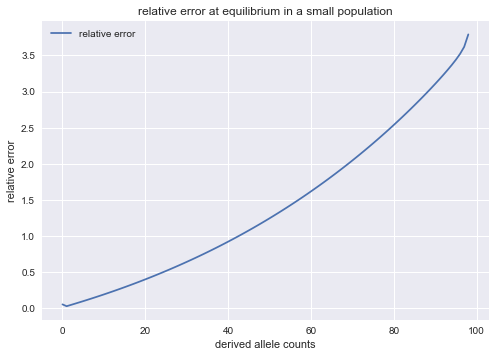

In [191]:
plt.plot((moment_smallpop_equil - WF_smallpop_equil)/WF_smallpop_equil ,label = "relative error")
plt.title("relative error at equilibrium in a small population")


plt.xlabel("derived allele counts")
plt.ylabel("relative error")
plt.legend(loc = "upper left")

In [192]:
n_generations = 1000
list_sfs_moments = [list_sfs_WF[0]]


for _ in range(n_generations):
    list_sfs_moments.append(np.dot(moment_matrix_small_del[1:,1:],list_sfs_moments[-1]) + z)

Text(0, 0.5, 'frequency')

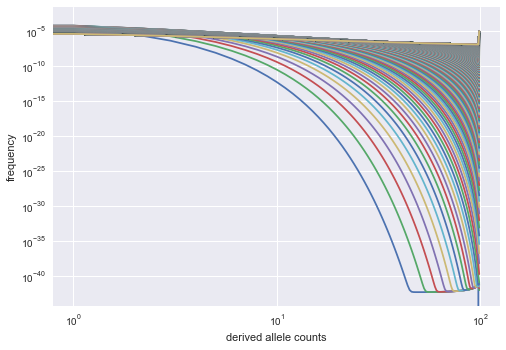

In [193]:
[plt.loglog(sfs) for sfs in list_sfs_moments];

plt.xlabel("derived allele counts")
plt.ylabel("frequency")



Text(0, 0.5, 'frequency')

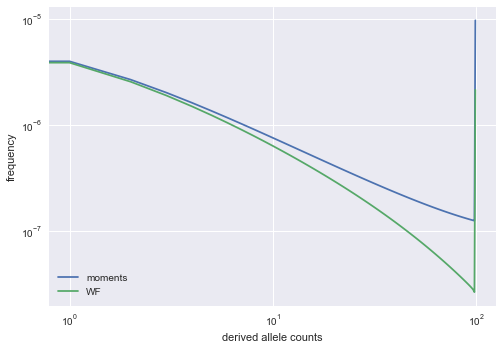

In [194]:
compare_generation = 999

plt.loglog(list_sfs_moments[compare_generation],label = "moments")
plt.loglog(list_sfs_WF[compare_generation],label = "WF")
plt.legend(loc="lower left")

plt.xlabel("derived allele counts")
plt.ylabel("frequency")


relative error in (n-1)-tons

In [195]:
array_moments = np.array(list_sfs_moments)
array_WF = np.array(list_sfs_WF)

Text(0.5, 1.0, 'fixation following a bottleneck')

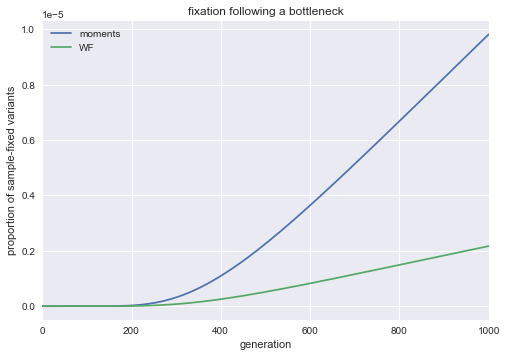

In [215]:
frequency_bin_to_plot = -1

plt.plot(array_moments[:,frequency_bin_to_plot], label = "moments")
plt.plot(array_WF[:,frequency_bin_to_plot], label = "WF")
plt.xlabel("generation")
plt.ylabel("proportion of sample-fixed variants")
plt.legend(loc="upper left")
plt.xlim((0,1000))
plt.title("fixation following a bottleneck")


(0.0, 10.0)

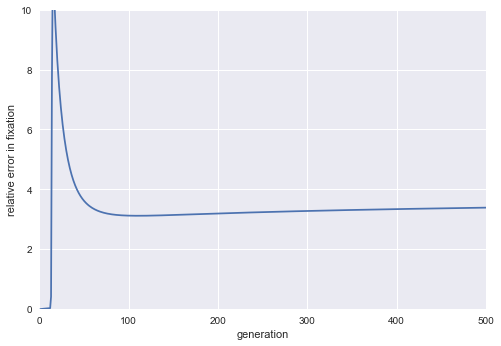

In [205]:
frequency_bin_to_plot = -1
plt.plot((array_moments[:,frequency_bin_to_plot]-array_WF[:,frequency_bin_to_plot])/array_WF[:,frequency_bin_to_plot], label = "moments")
plt.xlabel("generation")
plt.ylabel("relative error in fixation")
plt.xlim((0,500))
plt.ylim((0,10))

(0.0, 200.0)

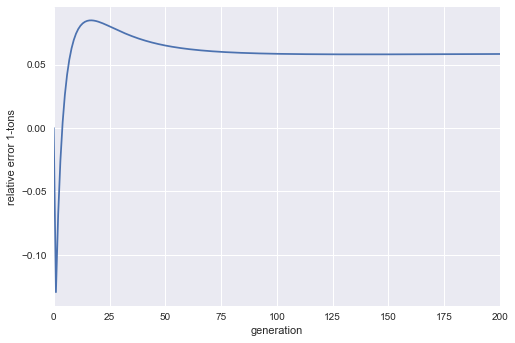

In [171]:
frequency_bin_to_plot = 1
plt.plot((array_moments[:,frequency_bin_to_plot]-array_WF[:,frequency_bin_to_plot])/array_WF[:,frequency_bin_to_plot], label = "moments")
plt.xlabel("generation")
plt.ylabel("relative error 1-tons")
plt.xlim((0,200))

Repeat for neutrality

In [172]:
n_generations = 1000
list_sfs_WF_neutral = [np.hstack((sfs_large_neutral,[0]))]  # Consider fixed mutations as well as polymorphisms 

for _ in range(n_generations):
    list_sfs_WF_neutral.append(np.dot(QT_bottle_neutral.transpose()[1:,1:],list_sfs_WF_neutral[-1]) + z)

NameError: name 'sfs_large_neutral' is not defined

In [ ]:
[plt.loglog(sfs) for sfs in list_sfs_WF_neutral[:100]];

In [ ]:
moment_matrix_neutral = scipy.linalg.expm(D_matrix)



In [ ]:
n_generations = 1000
list_sfs_moments_neutral = [list_sfs_WF_neutral[0]]

for _ in range(n_generations):
    list_sfs_moments_neutral.append(np.dot(moment_matrix_neutral[1:,1:],list_sfs_moments_neutral[-1]) + z)

In [ ]:
array_moments_neutral = np.array(list_sfs_moments_neutral)
array_WF_neutral = np.array(list_sfs_WF_neutral)

In [ ]:
frequency_bin_to_plot = -1

plt.plot(array_moments_neutral[:,frequency_bin_to_plot], label = "moments")
plt.plot(array_WF_neutral[:,frequency_bin_to_plot], label = "WF")
plt.xlabel("generation")
plt.ylabel("proportion of (n-1)-tons")

plt.legend(loc = "upper right")


In [173]:
frequency_bin_to_plot = -1
plt.plot((array_moments_neutral[:,frequency_bin_to_plot]-array_WF_neutral[:,frequency_bin_to_plot])/array_WF_neutral[:,frequency_bin_to_plot], label = "moments")
plt.xlabel("generation")
plt.ylabel("relative error (n-1)-tons")
plt.xlim((0,200))


NameError: name 'array_moments_neutral' is not defined

Text(0, 0.5, 'proportion of (n-1)-tons')

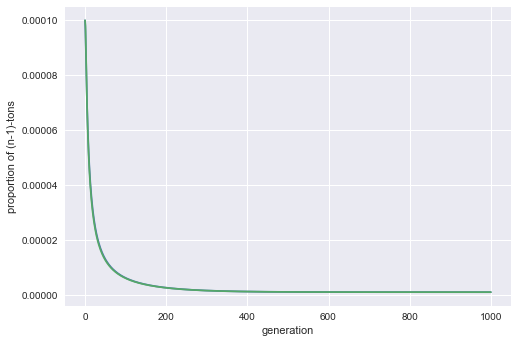

In [42]:
frequency_bin_to_plot = 1

plt.plot(array_moments_neutral[:,frequency_bin_to_plot], label = "moments")
plt.plot(array_WF_neutral[:,frequency_bin_to_plot], label = "WF")
plt.xlabel("generation")
plt.ylabel("proportion of (n-1)-tons")

(0.0, 200.0)

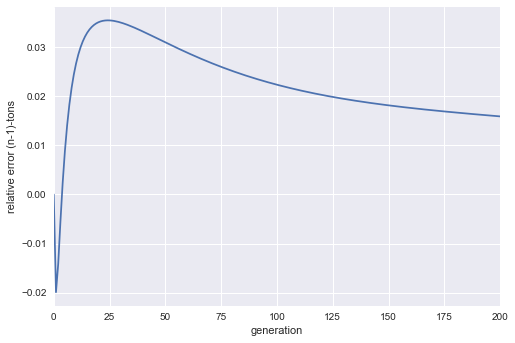

In [43]:
frequency_bin_to_plot = 1
plt.plot((array_moments_neutral[:,frequency_bin_to_plot]-array_WF_neutral[:,frequency_bin_to_plot])/array_WF_neutral[:,frequency_bin_to_plot], label = "moments")
plt.xlabel("generation")
plt.ylabel("relative error (n-1)-tons")
plt.xlim((0,200))

Text(0.5, 0, 'Generation after bottleneck')

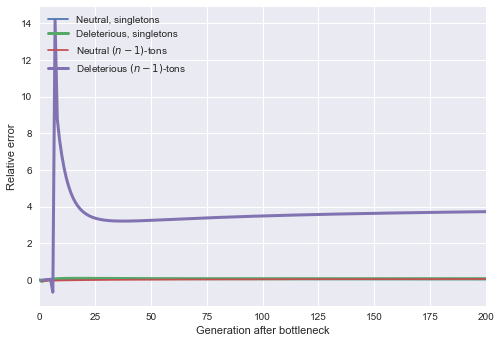

In [44]:
frequency_bin_to_plot = 1

plt.plot((array_moments_neutral[:,frequency_bin_to_plot]-array_WF_neutral[:,frequency_bin_to_plot])
         /array_WF_neutral[:,frequency_bin_to_plot], label="Neutral, singletons")

plt.plot((array_moments[:,frequency_bin_to_plot]-array_WF[:,frequency_bin_to_plot])
         /array_WF[:,frequency_bin_to_plot], lw=3, label="Deleterious, singletons")

frequency_bin_to_plot = -1

plt.plot((array_moments_neutral[:,frequency_bin_to_plot]-array_WF_neutral[:,frequency_bin_to_plot])
         /array_WF_neutral[:,frequency_bin_to_plot], label="Neutral $(n-1)$-tons")

plt.plot((array_moments[:,frequency_bin_to_plot]-array_WF[:,frequency_bin_to_plot])/
         array_WF[:,frequency_bin_to_plot], lw=3, label="Deleterious $(n-1)$-tons")


plt.xlim((0,200))
plt.legend(loc="upper left")
plt.ylabel("Relative error")
plt.xlabel("Generation after bottleneck")

There is something happening extraordinarily fast, specifically for the $n-1$-tons. LEt us look at this in case it is just a bug. 

Text(0.5, 0, 'Generation after bottleneck')

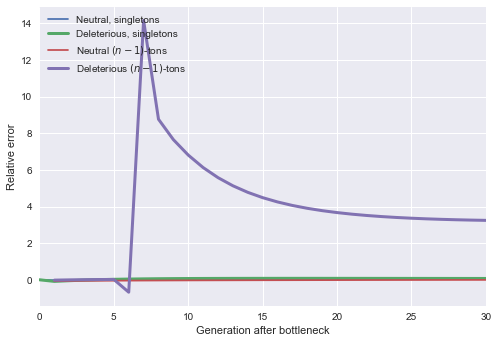

In [45]:
frequency_bin_to_plot = 1

plt.plot((array_moments_neutral[:,frequency_bin_to_plot]-array_WF_neutral[:,frequency_bin_to_plot])
         /array_WF_neutral[:,frequency_bin_to_plot], label="Neutral, singletons")

plt.plot((array_moments[:,frequency_bin_to_plot]-array_WF[:,frequency_bin_to_plot])
         /array_WF[:,frequency_bin_to_plot], lw=3, label="Deleterious, singletons")

frequency_bin_to_plot = -1

plt.plot((array_moments_neutral[:,frequency_bin_to_plot]-array_WF_neutral[:,frequency_bin_to_plot])
         /array_WF_neutral[:,frequency_bin_to_plot], label="Neutral $(n-1)$-tons")

plt.plot((array_moments[:,frequency_bin_to_plot]-array_WF[:,frequency_bin_to_plot])/
         array_WF[:,frequency_bin_to_plot], lw=3, label="Deleterious $(n-1)$-tons")


plt.xlim((0,30))
plt.legend(loc="upper left")
plt.ylabel("Relative error")
plt.xlabel("Generation after bottleneck")

(0.0, 500.0)

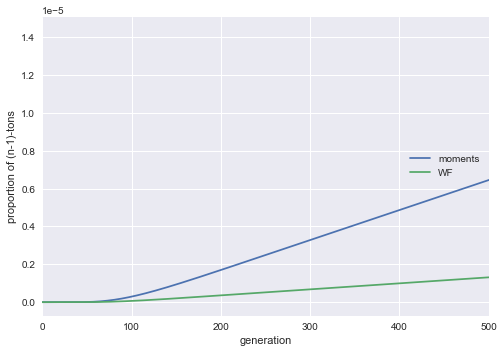

In [46]:
frequency_bin_to_plot = -1

plt.plot(array_moments[:,frequency_bin_to_plot], label = "moments")
plt.plot(array_WF[:,frequency_bin_to_plot], label = "WF")
plt.xlabel("generation")
plt.ylabel("proportion of (n-1)-tons")
plt.legend(loc="center right")
plt.xlim((0,500))




So if there is not problem, what is going on is that the rate of fixation is higher, overall, and more specifically that the fixation starts quite a bit earlier. 

(0.0, 200.0)

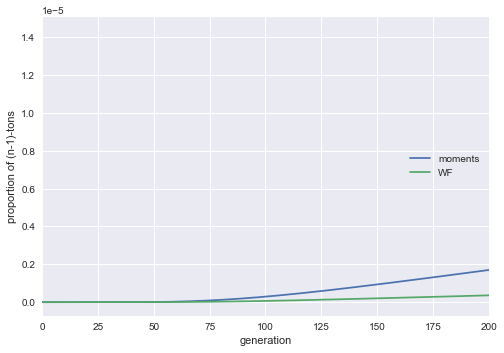

In [47]:
frequency_bin_to_plot = -1

plt.plot(array_moments[:,frequency_bin_to_plot], label = "moments")
plt.plot(array_WF[:,frequency_bin_to_plot], label = "WF")
plt.xlabel("generation")
plt.ylabel("proportion of (n-1)-tons")
plt.legend(loc="center right")
plt.xlim((0,200))

